In [1]:
# -*- coding: utf-8 -*-
# @author: tongzi
# @created date: 2019/07/24
# @description: Data Aggregation and Gouping Operations
# @last modification:2019/07/14

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

Categorizing a dataset and applying a function to each group, whether aggregation or transformation, is often a critical component of a data analysis workflow. After loading, merging, and prepraring a dataset, we may need to compute group statistics or possibly *pivot tables* for reporting or visualization purposes. *pandas* provides a flexible *groupby*() interface, enabling us to slice, dice, and summary dataset in a natural way.

One reason for the popularity of relational databases and SQL (which stands for structured query language) is the ease with whcih data can be joined, filtered, transformed, and aggregated. However, query languages like SQL are somewhat constrained in the kind of group operations that can be performed. As we will see, with the expressiveness of Python and pandas, we can perform quit compplex group operations by utilizing any function that accepts a pandas object or NumPy array. In this chapter,we will learn how to:  
(1)Splits a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame columns)  
  
(2)Calculate group summary statistics, like count, mean, standard deviation or user-defined function  
  
(3)Apply within-group transformation or other manipulations, like normalization, linear regression, rank, or subset selection.  
  
(4)Compute pivot table and cross tabulations  
  
(5)Perform quantile analysis and other statistical analysis.

  
  
  

>Aggregation for time series data, a special case of groupby, is referred to as *resampling*() in this book and will receive treatment in Chapter 11.

### 10.1 GroupBy Mechanics

Hadly Wickham,很多R编程语言流行包的作者，为描述分组操作创造一个术语“split-apply-combine”（分隔，应用，组合）。该过程的第一个阶段中，一个pandas对象中的数据不论是Series，DataFrame或者其它类型的数据会根据一个或者多个提供的键被分割成一个个组。分割操作是在一个对象的某个特定轴进行。比如说，一个DataFrame可以按照行或者列进行分割。分割完成后，每一个组应用一个函数并产生一个新的值。最后，所有应用到每个组的函数的结果组合到一起。组合的结果其形式取决于对数据执行了怎样的操作。如图所示：  
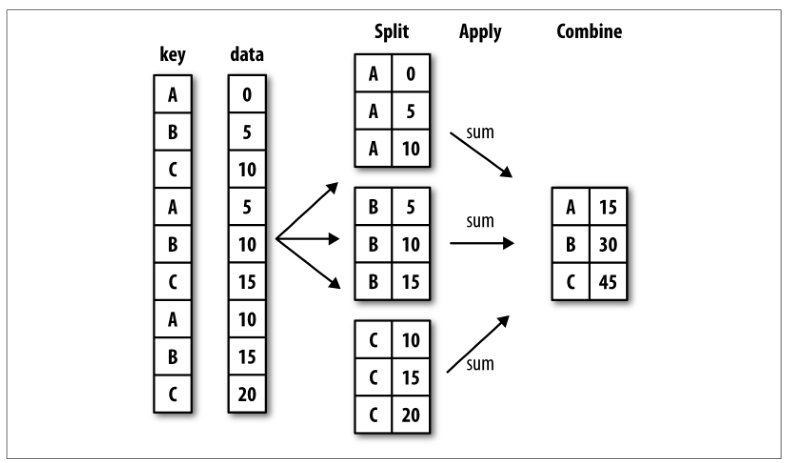

每一个分组的键可以是多种形式的，不一定都是相同的类型：  
（1）一个列表或者数组，其中的值和要被分组的轴在长度是相等的  
（2）DataFrame中的一个列名  
（3）一个字典或者Series，它给出了要给分组的轴的值与该组名字的对应关系  
（4）一个函数，该函数在轴索引或某索引的单个标签上进行调用

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
....: 'key2' : ['one', 'two', 'one', 'two', 'one'],
....: 'data1' : np.random.randn(5),
....: 'data2' : np.random.randn(5)})

In [4]:
df

,data1,data2,key1,key2
0,0.714162,-0.917054,a,one
1,-0.251975,-0.335887,a,two
2,0.056946,-2.165745,b,one
3,0.718219,2.431233,b,two
4,-0.388676,-1.043849,a,one


Suppose we want to compute the mean of the *data1* using the labels frin *key1*. There are a number of ways to do this, One is to access *data1* and call *groupby*() with the column (a Series) at *key1*: 

In [5]:
grouped = df['data1'].groupby(df['key1'])

In [6]:
grouped

This *grouped* variable is now a GroupBy object. It has not actualy computed anything except for some intermediate data about the group key df['key1']. The idea is that this object has all of the information needed to apply some group operation to each of the groups. For example, to compute group means we can the GoupBy's *mean*() method:

In [7]:
grouped.mean()

key1
a    0.024504
b    0.387583
Name: data1, dtype: float64

Later, we will explain more about what happens when we call *.mean*(). The important thing here is that the data (Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the *key1* column.  
  
The result index has the name 'key1' because the DataFrame column df['key1'] did.  
  
If instead we had passed multiple arrays as a list, we'd get something different:

In [8]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [9]:
means

key1  key2
a     one     0.162743
      two    -0.251975
b     one     0.056946
      two     0.718219
Name: data1, dtype: float64

Here we grouped the data using two keys, and the resulting Series has a hierarchical index consisting of the unique pairs of keys observed.

In [10]:
means.unstack()

key2,one,two
key1,,
a,0.162743,-0.251975
b,0.056946,0.718219


In this example, the group keys are all Series, though they can be any arrays of the right length:

In [11]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [12]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [13]:
df['data1'].groupby([states, years]).mean()

California  2005   -0.251975
            2006    0.056946
Ohio        2005    0.716191
            2006   -0.388676
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you work on. In that case, we can pass column names (whether those are strings, numbers, or other Python object) as the group keys:

In [14]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.024504,-0.765597
b,0.387583,0.132744


In [15]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.162743 -0.980452
     two  -0.251975 -0.335887
b    one   0.056946 -2.165745
     two   0.718219  2.431233

You may have noticed in the first case *df['key1'].mean*() that there is no *key2* column in the result. Because *df['key2']* is not numeric data, it is said to a *nuisance column* (讨厌的列), which is excluded from the result. By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset, as we'll see soon.

In [16]:
df

,data1,data2,key1,key2
0,0.714162,-0.917054,a,one
1,-0.251975,-0.335887,a,two
2,0.056946,-2.165745,b,one
3,0.718219,2.431233,b,two
4,-0.388676,-1.043849,a,one


Regardless of the objective in using *groupby*(), a generally useful GroupBy method is *size*(), which returns a Series containing group sizes:

In [17]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

>Take note that any missing values in a group key will be excluded from the result.

#### Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples (2元素元组) containing the group name along with the chunk of data. Consider the following:

In [18]:
list(df.groupby('key1'))

[('a',       data1     data2 key1 key2
  0  0.714162 -0.917054    a  one
  1 -0.251975 -0.335887    a  two
  4 -0.388676 -1.043849    a  one), ('b',       data1     data2 key1 key2
  2  0.056946 -2.165745    b  one
  3  0.718219  2.431233    b  two)]

In [19]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0  0.714162 -0.917054    a  one
1 -0.251975 -0.335887    a  two
4 -0.388676 -1.043849    a  one
b
      data1     data2 key1 key2
2  0.056946 -2.165745    b  one
3  0.718219  2.431233    b  two


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [20]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0  0.714162 -0.917054    a  one
4 -0.388676 -1.043849    a  one
('a', 'two')
      data1     data2 key1 key2
1 -0.251975 -0.335887    a  two
('b', 'one')
      data1     data2 key1 key2
2  0.056946 -2.165745    b  one
('b', 'two')
      data1     data2 key1 key2
3  0.718219  2.431233    b  two


Of course, we can choose to whateve we want with the pieces of data, A recipe you may find useful is computing a dict of the pieces as one-liner (一行)：

In [21]:
pieces = dict(list(df.groupby('key1')))

In [22]:
pieces['a']

,data1,data2,key1,key2
0,0.714162,-0.917054,a,one
1,-0.251975,-0.335887,a,two
4,-0.388676,-1.043849,a,one


By default, *groupby*() groups on axis=0, but we can group on any of the  other axes. For example, we could group the columns of our example *df* by **dtype** like so:

In [23]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [24]:
grouped = df.groupby(df.dtypes, axis=1)

We can print out the groups like so:

In [25]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  0.714162 -0.917054
1 -0.251975 -0.335887
2  0.056946 -2.165745
3  0.718219  2.431233
4 -0.388676 -1.043849
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


#### Selecting a Column or Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of column names has the effect of column subsetting for aggregation. This means that:

&emsp;&emsp;*df.groupby('key1')['data1']*   
&emsp;&emsp;*df.groupby('key1')[['data2']]*

are syntactic sugar for:

&emsp;&emsp;*df['data1'].groupby(df['key1'])*  
&emsp;&emsp;*df[['data2']].groupby(df['key2'])*

In [26]:
df['data2'] # 这种方式会返回一个Series对象

0   -0.917054
1   -0.335887
2   -2.165745
3    2.431233
4   -1.043849
Name: data2, dtype: float64

In [27]:
df[['data2']] # 这种方式会返回一个DataFrame对象

,data2
0,-0.917054
1,-0.335887
2,-2.165745
3,2.431233
4,-1.043849


对于大的数据集，可能指向聚合一列数据，比方说，在前面的数据集中，只想计算*data2*列的均值，并且其结果作为一个DataFrame返回，可以写：

In [28]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one  -0.980452
     two  -0.335887
b    one  -2.165745
     two   2.431233

The object returned by this indexing operation is a grouped DataFrame if a list or array is passed or a grouped Series if only a single column name is passed as a scalar:

In [29]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [30]:
s_grouped

In [31]:
s_grouped.mean()

key1  key2
a     one    -0.980452
      two    -0.335887
b     one    -2.165745
      two     2.431233
Name: data2, dtype: float64

#### Grouping with Dicts and Series

In [32]:
people = pd.DataFrame(np.random.randn(5, 5),
....: columns=['a', 'b', 'c', 'd', 'e'],
....: index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [33]:
people.iloc[2:3, [1,2]] = np.nan

In [34]:
people

,a,b,c,d,e
Joe,-0.840949,-0.712837,0.385332,0.843450,-0.938942
Steve,0.393219,0.398256,0.401803,-1.538065,1.365792
Wes,-0.126382,NaN,NaN,-0.426163,0.657845
Jim,0.873312,-0.739668,-0.121883,-0.450816,0.770976
Travis,-0.397205,-0.346472,0.656310,-0.438620,0.205482


Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [35]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
....: 'd': 'blue', 'e': 'red', 'f' : 'orange'}

Now we can construct an array from this dict to pass to *groupby*(), but instead we can just the dict (I included the key *'f'* to highlight that unused grouping keys are OK):

In [36]:
by_column = people.groupby(mapping, axis=1)

In [37]:
by_column.sum()

,blue,red
Joe,1.228782,-2.492729
Steve,-1.136261,2.157267
Wes,-0.426163,0.531463
Jim,-0.572699,0.904620
Travis,0.217690,-0.538195


The same functionality holds for Series, which can be viewed as a fix-size mapping:

In [38]:
map_series = pd.Series(mapping)

In [39]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [40]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


Using Python function is a more generic way of defining a group mapping compared with a dict or Series. **Any function passed as group key will be called once per index value, with the returned values being used as the group names.** More concretely, consider the example DataFrame from the previous section, which has people's first names as index values. Suppose we want to group by the lenght of the names; while we could compute an array of string lenghts, it's simpler to just pass the *len*() function:

In [41]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.094019,-1.452505,0.263449,-0.033529,0.489879
5,0.393219,0.398256,0.401803,-1.538065,1.365792
6,-0.397205,-0.346472,0.656310,-0.438620,0.205482


In [42]:
list(people.groupby(len))

[(3,             a         b         c         d         e
  Joe -0.840949 -0.712837  0.385332  0.843450 -0.938942
  Wes -0.126382       NaN       NaN -0.426163  0.657845
  Jim  0.873312 -0.739668 -0.121883 -0.450816  0.770976),
 (5,               a         b         c         d         e
  Steve  0.393219  0.398256  0.401803 -1.538065  1.365792),
 (6,                a         b        c        d         e
  Travis -0.397205 -0.346472  0.65631 -0.43862  0.205482)]

Mixing function with dicts, arrays or Series is not a problem as evething gets converted to array internally:

In [43]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [44]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.840949 -0.712837  0.385332 -0.426163 -0.938942
  two  0.873312 -0.739668 -0.121883 -0.450816  0.770976
5 one  0.393219  0.398256  0.401803 -1.538065  1.365792
6 two -0.397205 -0.346472  0.656310 -0.438620  0.205482

In [45]:
list(people.groupby(key_list))

[('one',               a         b         c         d         e
  Joe   -0.840949 -0.712837  0.385332  0.843450 -0.938942
  Steve  0.393219  0.398256  0.401803 -1.538065  1.365792
  Wes   -0.126382       NaN       NaN -0.426163  0.657845),
 ('two',                a         b         c         d         e
  Jim     0.873312 -0.739668 -0.121883 -0.450816  0.770976
  Travis -0.397205 -0.346472  0.656310 -0.438620  0.205482)]

In [46]:
people

,a,b,c,d,e
Joe,-0.840949,-0.712837,0.385332,0.843450,-0.938942
Steve,0.393219,0.398256,0.401803,-1.538065,1.365792
Wes,-0.126382,NaN,NaN,-0.426163,0.657845
Jim,0.873312,-0.739668,-0.121883,-0.450816,0.770976
Travis,-0.397205,-0.346472,0.656310,-0.438620,0.205482


#### Grouping by Index Levels

A final convenience for hierarchically indexex datasets is the ability to aggregate using one of the levels of an axis index. Let's look at an example:

In [47]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
....: [1, 3, 5, 1, 3]],
....: names=['cty', 'tenor'])

In [48]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [49]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.265282  1.101794 -1.100412 -0.334982 -1.931610
1     -1.071204  0.763616  0.841652  0.437332 -0.122405
2     -0.983273  0.593081  0.648976 -0.414249  0.327547
3     -1.779847 -0.507833  0.398431 -1.744622  1.616412

To group by level, pass the level number or name using the *level* keyword:

In [50]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays. The preceding examples have used several of them, including *mean*, *std*, *count*, *min*, *max*, and *sum*. We may wonder what's going on when we invoke *mean*() method on a GroupBy object. Many commmon aggragations, sucn as those found in table below, have optimized impplementations. However, we are not limited to only this set of methods.

Table 10-1
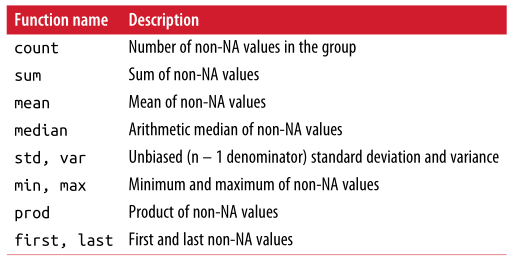

We can use aggregations of our own devising and additionally call any method that is also defined on the grouped object. For example, we might recall that  *quantile*() computes the sample quantiles of a Series or a DataFrame's column.  
  
While *quantile*() is not explicitly implemented for GroupBy, it is a Series method and thus available for use. Internally, GroupBy efficiently slice up the Series, calls *piece.quantile*(0.9) for each piece, and then assembles those results together into the result object:

In [51]:
df

,data1,data2,key1,key2
0,0.714162,-0.917054,a,one
1,-0.251975,-0.335887,a,two
2,0.056946,-2.165745,b,one
3,0.718219,2.431233,b,two
4,-0.388676,-1.043849,a,one


In [52]:
grouped = df.groupby('key1')

In [53]:
list(grouped)

[('a',       data1     data2 key1 key2
  0  0.714162 -0.917054    a  one
  1 -0.251975 -0.335887    a  two
  4 -0.388676 -1.043849    a  one), ('b',       data1     data2 key1 key2
  2  0.056946 -2.165745    b  one
  3  0.718219  2.431233    b  two)]

In [54]:
list(grouped['data1'])

[('a', 0    0.714162
  1   -0.251975
  4   -0.388676
  Name: data1, dtype: float64), ('b', 2    0.056946
  3    0.718219
  Name: data1, dtype: float64)]

In [55]:
grouped['data1'].quantile()

key1
a   -0.251975
b    0.387583
Name: data1, dtype: float64

In [56]:
grouped['data1'].quantile(0.9)

key1
a    0.520934
b    0.652092
Name: data1, dtype: float64

Let's consider am example to understand quantile:

In [57]:
ser = pd.Series([1, 2, 3, 4, 5])

In [58]:
ser

0    1
1    2
2    3
3    4
4    5
dtype: int64

In [59]:
ser.quantile(0.5)

3.0

In [60]:
ser.quantile(0.9)

4.6

In [61]:
ser.quantile([0.25, 0.5, 0.75, 1.0])

0.25    2.0
0.50    3.0
0.75    4.0
1.00    5.0
dtype: float64

To use our own aggregation functions, pass any function that aggregates an array to the *aggregate*() or *agg*() method:

In [62]:
# define a function for aggregating
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [63]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.102838,0.707962
b,0.661273,4.596978


We may notice that some methods like *describe*() are also work, even though they are not aggregations, strictly speaking:

In [64]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.024504  0.601160 -0.388676 -0.320326 -0.251975  0.231093   
b      2.0  0.387583  0.467591  0.056946  0.222265  0.387583  0.552901   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     0.714162   3.0 -0.765597  0.377501 -1.043849 -0.980452 -0.917054   
b     0.718219   2.0  0.132744  3.250554 -2.165745 -1.016500  0.132744   

                          
           75%       max  
key1                      
a    -0.626470 -0.335887  
b     1.281989  2.431233

>Custom aggregation function are generally much slower than the optimized functions. This is because there is some extra overhead (function calls, data rearrangement) in constructing the intermediate group data chuncks.

Column-Wise and Multiple Function Application

Let's return to the tipping dataset from the earlier examples. After loading it with *read_csv*(), we add a tipping percentage column *tip_pct*:

In [65]:
tips = pd.read_csv("./examples/tips.csv")

In [66]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [67]:
tips[:5]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


As we've already seen, aggregating a Series or all of the columns in a DataFrame is a matter of using *aggregate*() with the desired function or calling a method like *mean*() or *std*. However, we may want to aggregate using different function depending on the column, or multiple functions at once. Fortunately, this is possible to do, which we'll illustrate through a number of examples. First, I'll group the *tips* by day and *smoker*:

In [68]:
grouped = tips.groupby(['day', 'smoker'])

Note that for descriptive statistics like those in Table 10-1, we can pass the name of the function as string:

In [69]:
grouped_pct = grouped['tip_pct']

In [70]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

If we pass a list of functions or function names instead, we get back a DataFrame with the column names taken from the functions:

In [71]:
grouped_pct.agg(['std', 'mean', peak_to_peak])

std      mean  peak_to_peak
day  smoker                                  
Fri  No      0.028123  0.151650      0.067349
     Yes     0.051293  0.174783      0.159925
Sat  No      0.039767  0.158048      0.235193
     Yes     0.061375  0.147906      0.290095
Sun  No      0.042347  0.160113      0.193226
     Yes     0.154134  0.187250      0.644685
Thur No      0.038774  0.160298      0.193350
     Yes     0.039389  0.163863      0.151240

Here we passed a list of aggregation function to evaluate indenpendently on the data groups.  
  
We don't need to accept the names that GroupBy gives to the columns; notably, *lambda* functions have the name "<lambda>", which makes them hard to identify. Thus, if we pass a list of (name, function) tuples, the first element of each tuple will be used as the DataFrame column names, for example:

In [72]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

With a DataFrame we have more options, as we can specify a list of functions to apply to all of columns or defferent function per column. To start, suppose we want to compute the same three statistics for the *tip_pct* and *total_bill* columns:

In [73]:
functions = ['count', 'mean', 'max']

In [74]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

In [75]:
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

As we can see, the resulting DataFrame has a hierarchical columns, the same as we would get the aggregating each column separately and using *concat*() to glue the results together using column names as the keys argument:

In [76]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

As before, a list of tuples with custom names can be passed:

In [77]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [78]:
# 所选择的列应用相同的函数
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Now, suppose we wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to *agg*() that contains a mapping of column names to any of function specifications listed so far:

In [79]:
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [80]:
# 不同的列使用不同的函数
grouped.agg({'tip_pct':['min', 'max', 'mean', 'std'], 'size': 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

A DataFrame will have hierarchical columns only if multiple functions are apply to at least one column.

Returning Aggregated Data Without Row Indexes

In all of the examples up until now, the aggregated data comes back with an index potentially hierarchical, composed from the unique group key combinations. Since this isn't always desirable, we can disable this in most cases by passing *as_index=False* to *groupby*():

In [81]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


Of course, it's always to obtain the result in this format by calling *reset_index*() on the result. Using the *as_index=False* method avoids some unneccessary computations.

### 10.3 Apply: General split-apply-combine

The most general-purpose GroupBy method is *apply*(), which is the subject of the rest of this section. As illustrated in Fig 10.2, *apply*() splits the object being manipulated into pieces, invokes the passed function on each piece, and then attempts to comcanetate the pieces together.  
![image.png](attachment:image.png "Fig 10.2")
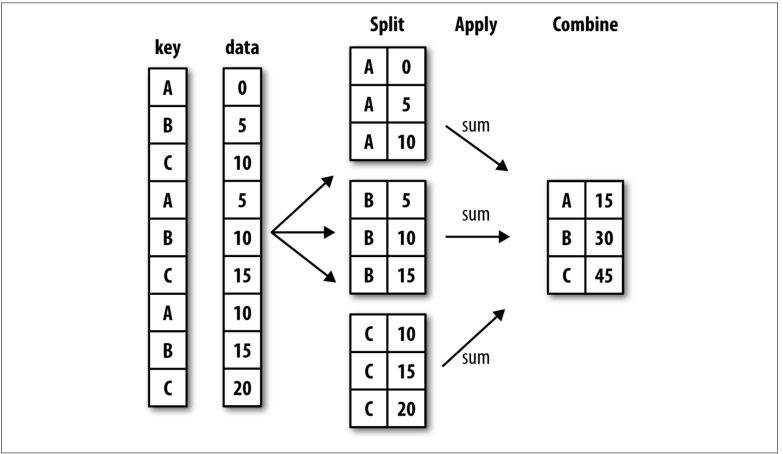

In [82]:
tips.sort_values(by='tip_pct')[-5:]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [84]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [85]:
top(tips, n=8)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
93,16.32,4.30,Female,Yes,Fri,Dinner,2,0.263480
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [86]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

What happened here? The *top*() function is called on each row group from the DataFrame, and then the results are glued together by *pandas.concat*(), labeling the pieces with the group names. The results therefore have a hierarchical index whose inner level contains index values from the original DataFrame.  
  
If we pass a function to *apply*() that takes other arguments or keywords, we can pass these after the function:

In [87]:
tips.groupby(['smoker', 'day']).apply(top, n=2, column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  91        22.49   3.50    Male     No   Fri  Dinner     2   
            94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  59        48.27   6.73    Male     No   Sat  Dinner     4   
            212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  112       38.07   4.00    Male     No   Sun  Dinner     3   
            156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 85        34.83   5.17  Female     No  Thur   Lunch     4   
            142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  90        28.97   3.00    Male    Yes   Fri  Dinner     2   
            95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  102       44.30   2.50  Female    Yes   Sat  Dinner     3   
            170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  184       40.55   3.00    Male    Yes   Sun  Dinner     2   
            182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 83        32.68   5.00    Male    Yes  Thur   Lunch     2   
            197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  91   0.155625  
            94   0.142857  
       Sat  59   0.139424  
            212  0.186220  
       Sun  112  0.105070  
            156  0.103799  
       Thur 85   0.148435  
            142  0.121389  
Yes    Fri  90   0.103555  
            95   0.117750  
       Sat  102  0.056433  
            170  0.196812  
       Sun  184  0.073983  
            182  0.077178  
       Thur 83   0.152999  
            197  0.115982

>Beyond these basic usage mechanics, getting the most out of *apply*() may require some creativity. What occurs inside the function passed is up to you; it only needs to return a pandas object or a scalar value. The rest of this chapter will mainly consist of examples showing you how solve various problems using *groupby*().

In [89]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [90]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [91]:
result.unstack()

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

Inside a GroupBy, when you invoke a method like *describe*(), it is usually just a shortcut for:  
```python
  f = lambda x: x.describe()
  grouped.apply(f)
```

### Suppressing the Group Keys

In the preceding examples, we can see that the resulting object has a herarchical index formed from the group keys along with the indexes of each piece of the original object. We can disable this by passing *group_keys=False* to *groupby*():

In [92]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [94]:
tips.groupby('smoker', group_keys=True).apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

### Quantile and Bucket

As we may recall that in Chapter 8, pandas has some tools, in particular *cut*() nad *qcut*(), for slicing data up into buckets with the bins of our choosing or by samples quantiles. Combining these functions with *groupby*() makes it convenient to perform bucket or quantile analysis on a dataset. Consider a simple random dataset and an equal-length bucket categorization using *cut*():

In [95]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                     'data2': np.random.randn(1000)})

In [97]:
quantiles = pd.cut(frame.data1, 4)

In [98]:
quantiles[:10]

0     (-0.517, 1.194]
1    (-2.228, -0.517]
2    (-2.228, -0.517]
3     (-0.517, 1.194]
4    (-2.228, -0.517]
5     (-0.517, 1.194]
6     (-0.517, 1.194]
7    (-2.228, -0.517]
8     (-0.517, 1.194]
9      (1.194, 2.905]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.945, -2.228] < (-2.228, -0.517] < (-0.517, 1.194] < (1.194, 2.905]]

The Categorical object returned by *cut*() can be passed to *groupby*(). So we could compute a set of statistics for the *data2* column like so:

In [99]:
def get_stats(group):
    return {'min':group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean()}

In [100]:
grouped = frame.data2.groupby(quantiles)

In [101]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.945, -2.228]",16.0,0.916305,-0.374944,-1.224791
"(-2.228, -0.517]",280.0,2.630693,-0.079320,-2.935569
"(-0.517, 1.194]",579.0,3.293577,-0.005313,-3.206498
"(1.194, 2.905]",125.0,3.293069,0.127818,-2.134369


These are equal-lenght bucketl to compute equal-size buckets based on sample quantiles, use *qcut*(). I'll pass *labels=False* to just get quantile numbers:

In [108]:
grouping = pd.qcut(frame.data1, 10, labels=False)

In [105]:
grouped = frame.data2.groupby(grouping)

In [106]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.226598,-0.233634,-2.813975
1,100.0,2.630693,-0.005260,-2.935569
2,100.0,2.051488,-0.040795,-1.949513
3,100.0,2.405505,-0.121140,-1.918317
4,100.0,3.045885,0.111722,-3.019736
5,100.0,3.293577,0.074979,-2.138791
6,100.0,2.432510,0.001161,-1.851976
7,100.0,2.478080,-0.030876,-2.407779
8,100.0,3.293069,0.031796,-3.206498


#### Example: Filling Missing Values with Group-Specific Values

When cleaning up missing data, in some cases we will replace data observations using *dropna*(), but in others we may want to impute (fill in) the null values using a fixed value or some value derived from the data. *fillna*() is the right tool to use; for example, here I fill in NA values with the mean:

In [110]:
s = pd.Series(np.random.randn(6))

In [111]:
s[::2] = np.nan

In [112]:
s

0         NaN
1   -0.538433
2         NaN
3   -0.453895
4         NaN
5    0.398053
dtype: float64

In [113]:
s.fillna(s.mean())

0   -0.198092
1   -0.538433
2   -0.198092
3   -0.453895
4   -0.198092
5    0.398053
dtype: float64

Suppose we may want to fill value to vary by group. One way to do this is to group the data and use *apply*() with a function that calls on each data chunk. Here is some sample data on US states divided into eastern and western regions:

In [119]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']

In [120]:
group_key = ['East']*4 + ['West']*4

In [121]:
data = pd.Series(np.random.randn(8), index=states)

In [122]:
data

Ohio          1.895558
New York      1.324299
Vermont       3.328344
Florida      -1.442373
Oregon        1.122452
Nevada       -0.958831
California    0.423392
Idaho         0.250130
dtype: float64

>Note that the syntax ['East']*4 produces a list containing four copies of the element in ['East']. Adding list together concatenates them.  
  
Let's set some values in the data to be missing:

In [123]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [124]:
data

Ohio          1.895558
New York      1.324299
Vermont            NaN
Florida      -1.442373
Oregon        1.122452
Nevada             NaN
California    0.423392
Idaho              NaN
dtype: float64

In [125]:
data.groupby(group_key).mean()

East    0.592495
West    0.772922
dtype: float64

We can fill the NA using the group means likes so:

In [126]:
fill_mean = lambda g: g.fillna(g.mean())

In [127]:
data.groupby(group_key).apply(fill_mean)

Ohio          1.895558
New York      1.324299
Vermont       0.592495
Florida      -1.442373
Oregon        1.122452
Nevada        0.772922
California    0.423392
Idaho         0.772922
dtype: float64

In another case, we might have predefined fill values in our code that vary by group. Since the groups have a name attribute set internally, we can use that:

In [128]:
fill_values = {'East': 0.5, 'West': -1}

In [129]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [130]:
data.groupby(group_key).apply(fill_func)

Ohio          1.895558
New York      1.324299
Vermont       0.500000
Florida      -1.442373
Oregon        1.122452
Nevada       -1.000000
California    0.423392
Idaho        -1.000000
dtype: float64

#### Example: Random Sample and Permtation

Suppose we wanted to draw a random sample (with or without replacement) from a large dataset for Monte Carlo simulation purposes or some other application. There are a number of way to perform the "draws"; here we use the *sample*() method for Series.  
  
To demonstrate, here's way to construct a deck of English-style playing cards:

In [131]:
suits = ['H', 'S', 'C', 'D'] # Heart, Spades, Clubs, Diamonds

In [132]:
card_val = (list(range(1, 11)) + [10]*3)*4

In [134]:
base_names = ['A'] + list(range(2, 11)) + ['J', 'Q', 'K']

In [135]:
cards = []
for suit in suits:
    cards.extend(str(num) + suit for num in base_names)

In [136]:
deck = pd.Series(card_val, index=cards)

In [137]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
QH     10
KH     10
dtype: int64

Now, based on what I said before, drawing a hand of five cards from the deck could be written as:

In [144]:
def draw(deck, n=5):
    return deck.sample(n)

In [145]:
draw(deck)

4D    4
8S    8
2D    2
AS    1
8D    8
dtype: int64

Suppose we wanted two random cards from each suit. Because the suit is the last character of each card name, we could group based on this and use *apply*():

In [146]:
get_suit = lambda card: card[-1]

In [147]:
deck.groupby(get_suit).apply(draw, n=3)

C  8C      8
   5C      5
   10C    10
D  QD     10
   7D      7
   3D      3
H  6H      6
   KH     10
   2H      2
S  10S    10
   AS      1
   9S      9
dtype: int64

Alternatively, we could write:

In [149]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=3)

10C    10
AC      1
JC     10
3D      3
QD     10
KD     10
8H      8
QH     10
10H    10
9S      9
AS      1
6S      6
dtype: int64

#### Example: Group Weighted Average and Correlation

Under the split-apply-combine paradigm of *groupby*(), operations between columns in a DataFrame or two Series, such as a group weighted average, are possible. As an example, take this dataset containing keys, values, and some weights:

In [151]:
df = pd.DataFrame({"category": ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                 'data': np.random.randn(8), 
                 'weights': np.random.rand(8)})

In [152]:
df

,category,data,weights
0,a,0.988396,0.461152
1,a,-2.377541,0.913845
2,a,-0.338229,0.031887
3,a,0.123738,0.932333
4,b,0.806085,0.972196
5,b,-1.751842,0.757740
6,b,-0.128470,0.220630
7,b,1.315497,0.338298


The group weighted average by *category* would then be:

In [153]:
grouped = df.groupby('category')

In [154]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [155]:
grouped.apply(get_wavg)

category
a   -0.689258
b   -0.055522
dtype: float64

As another example, consider a financial dataset originally obtained from Yahoo! Finance containing end-of-day prices for a few stocks and the S&P 500 index (the SPX symbol):

In [157]:
close_px = pd.read_csv('./examples/stock_px_2.csv', parse_dates=True,
                      index_col=0)

In [158]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [159]:
close_px[-5:]

,AAPL,MSFT,XOM,SPX
2011-10-10,388.81,26.94,76.28,1194.89
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


One task of interest might be to compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with SPX. As a way to do this, we create a function to compute a pairwise correlation of each column with SPX:

In [160]:
spx_corr = lambda x: x.corrwith(x['SPX'])

Next, we compute percent changes on *close_px* using *pct_change*()):

In [161]:
rets = close_px.pct_change().dropna()

In [163]:
rets[:3]

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545


Lastly, we group these percent changes by year, which can be extracted from each low label with a one-line function that returns the *year* attribuet of each *datetime* label:

In [162]:
get_year = lambda x: x.year

In [164]:
by_year = rets.groupby(get_year)

In [168]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


We could also compute inter-column correlation. Here we compute the annual correlation between Apple and Microsoft:

In [170]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

#### Example: Group-Wise Linear Regression

In the same theme as the previous example, we can use *groupby*() to perform more complex group-wise statitstical analysis, as long as the function returns a pandas object or scalar. For example, we can define the following *regress*() function (using the statsmodels econometrics library), which executes an ordinary least square (OLS,最小二乘法) on each chunk of data:

In [171]:
import statsmodels.api as sm

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [198]:
def regress(data, yvar, xvars):
    #print(data)
    Y = data[yvar]
    X = data[xvars]
    #print(X[:5])
    X['intercept'] = 1.
    
    result = sm.OLS(Y, X).fit()
    return result.params

Now, to run a yearly linear regression of AAPL on SPX returns, execute:


In [199]:
ans = by_year.apply(regress, 'AAPL', ['SPX'])

### 10.4 Pivot Table (数据透视表) and Cross-Tabulation (交叉表)

Returning to the tipping dataset, suppose we want to compute a table of group mean (the default *pandas.pivot_talbe*() aggregation type) arranged by *day* and *smoker* on the rows:

In [204]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

This operation tips.pivot_table(index=['day', 'smoker']) is equivalent to:

In [205]:
tips.groupby(['day', 'smoker']).apply(np.mean)

total_bill       tip      size   tip_pct
day  smoker                                          
Fri  No       18.420000  2.812500  2.250000  0.151650
     Yes      16.813333  2.714000  2.066667  0.174783
Sat  No       19.661778  3.102889  2.555556  0.158048
     Yes      21.276667  2.875476  2.476190  0.147906
Sun  No       20.506667  3.167895  2.929825  0.160113
     Yes      24.120000  3.516842  2.578947  0.187250
Thur No       17.113111  2.673778  2.488889  0.160298
     Yes      19.190588  3.030000  2.352941  0.163863

Now, suppose we want to aggregate only *tip_pct* and *size*, and additionaly group by time. I'll put *smoker* in the tables columns and *day* in the rows:

In [206]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns=['smoker'])

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

We could augment this table to include partial total by passing *margins=True*. This has the effect of adding *All* column and row labels, with corresponding values being the group statistics for all the data within a single tier:

In [207]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                columns=['smoker'], margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [208]:
(2.000000 + 2.555556 + 2.929825 + 2.000000 + 3 + 2.5 + 2.668874) / 7

2.5220364285714285

Here, the All values are means without taking into account smoker versus non-
smoker (the All columns) or any of the two levels of grouping on the rows (the All
row).  
**?????**

To use a different aggregation function, pass it to *aggfunc* argument. For example, 'count' or 'len' will give you a cross-tabulation (count or frequency) of group sizes:

In [210]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                                   aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

or use *np.count_nonzero* instead:

In [212]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day',
                                   aggfunc=np.count_nonzero, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

If some combination are empty (or otherwise NA), we may wish to pass a fill_value:

In [229]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

See the table below for a summary of *pivot_table*() methods:  
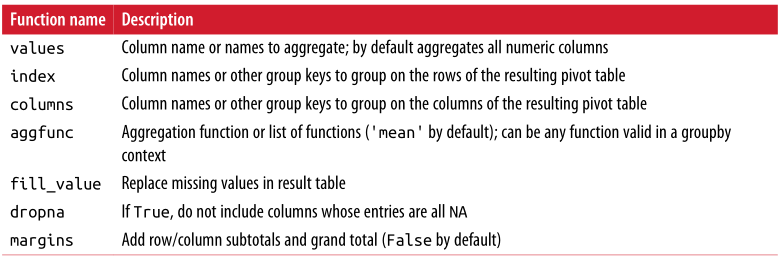

#### Cross-Tabulations: Crosstab

A cross-tabulation is special case of pivot table that computes group frequences. Here is an example:

In [231]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

The first two arguments to *pd.crosstab*() can either be an array or Series or a list of arrays.

本章完结！！！